# Paper Figures

In [155]:
import utils
import pandas as pd
import numpy as np

def drop_beta_feats(in_df):
    return in_df.drop(columns=['beta', 'modified-beta', 'mean_pcc', 'median_pcc', 'mad_pcc', 'lags'])

def drop_env_mfcc(in_df):
    to_drop = [
        "env_mfcc0_mean",
        "env_mfcc1_mean",
        "env_mfcc2_mean",
        "env_mfcc3_mean",
        "env_mfcc4_mean",
        "env_mfcc5_mean",
        "env_mfcc6_mean",
        "env_mfcc7_mean",
        "env_mfcc8_mean",
        "env_mfcc9_mean",
        "env_mfcc10_mean",
        "env_mfcc11_mean",
        "env_mfcc12_mean",
        "env_mfcc0_max",
        "env_mfcc1_max",
        "env_mfcc2_max",
        "env_mfcc3_max",
        "env_mfcc4_max",
        "env_mfcc5_max",
        "env_mfcc6_max",
        "env_mfcc7_max",
        "env_mfcc8_max",
        "env_mfcc9_max",
        "env_mfcc10_max",
        "env_mfcc11_max",
        "env_mfcc12_max"
    ]
    return in_df.drop(columns=to_drop)


# Candas2
candas2_feat = pd.read_csv("features2/candas2_features.csv", index_col=0)

# Safe-T
safe_t_feat = pd.read_csv("features2/safe_t_features.csv", index_col=0)

# Castor2
castor2_feat = pd.read_csv("features2/castor2_features.csv", index_col=0)

# Twin-GC
twin_gc_feat = pd.read_csv("features2/twin_gc_features.csv", index_col=0)

# Twin-TF
twin_tf_feat = pd.read_csv("features2/twin_tf_features.csv", index_col=0)

# TF second pick
tf_2nd_pick_feat = pd.read_csv("features2/tf_2nd_pick_features.csv", index_col=0)

# TF same day
tf_same_day_feat = pd.read_csv("features2/tf_same_day_features.csv", index_col=0)

# Castor
castor_feat = pd.read_csv("features2/castor_features.csv", index_col=0)

# Candas1
candas1_feat = pd.read_csv("features2/candas1_features.csv", index_col=0)

# Safe2
safe2_feat = pd.read_csv("features2/safe2_features.csv", index_col=0)

# Training set that will be split into train/test
data_train = pd.concat([castor2_feat, twin_gc_feat, twin_tf_feat, tf_2nd_pick_feat, tf_same_day_feat, castor_feat, candas1_feat, candas2_feat], axis=0, ignore_index=True)
data_train = drop_beta_feats(data_train)
data_train = drop_env_mfcc(data_train)

# Additional set for out-of-distibution analysis (events and cable never seen before)
data_ood = pd.concat([safe_t_feat, safe2_feat], axis=0, ignore_index=True)
data_ood =  drop_beta_feats(data_ood)
data_ood = drop_env_mfcc(data_ood)

In [156]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# We'll isolate the first features for outlier detection.
features = data_train.drop(columns='target')
target = data_train.loc[:, 'target']

# Compute IQR-based outlier bounds for each feature
mask = pd.Series(True, index=features.index)  # start with all True

for col in features.columns:
    Q1 = features[col].quantile(0.05)
    Q3 = features[col].quantile(0.95)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # For each column, find rows within the IQR bounds
    col_mask = features[col].between(lower_bound, upper_bound, inclusive='both')
    
    # Update the global mask (row must be in-bounds for *all* features to remain)
    mask = mask & col_mask

# Filter the DataFrame to keep only the rows that passed the mask for all features
clean_features = features[mask]
clean_target = target[mask]

print('Clean data ratio', len(clean_target)/len(data_train['target']))
# Reassemble the DataFrame 
data_cleaned = pd.concat([clean_features, clean_target], axis=1)

X = data_cleaned.drop(columns='target')
y = data_cleaned['target'] 

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# Scale the features for robustness
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, 
                              index=X_train.index, 
                              columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, 
                             index=X_test.index, 
                             columns=X_test.columns)


Clean data ratio 0.9276556962025316


In [148]:
selected_features = ['psd-kurtosis',
 'env-margin-factor',
 'env_freq-avg',
 'env-impulse-factor',
 'env-peak',
 'env-variance',
 '1-peak-prominence-factor',
 'env-psd-entropy',
 'psd-entropy',
 '3-peak-prominence-factor',
 'psd-skew',
 'env-median',
 'env-clearance-factor',
 'env-rms',
 'freq-skew', 'mfcc1_mean', 'mfcc1_max']


In [149]:
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix, 
    classification_report
)
    
# Subset the train and test data to only the selected features
X_train_subset = X_train_scaled[selected_features]
X_test_subset = X_test_scaled[selected_features]

xgb_clf_best = xgb.XGBClassifier(
    learning_rate=0.05,
    max_depth=4,
    gamma=5,
    n_estimators=500,
    subsample=0.75,
    colsample_bytree=0.5,
    min_child_weight=3,
    tree_method='hist',
    n_jobs=-1,
    random_state=42,
    eval_metric='auc',
    reg_lambda=10
)

# Fit the classifier on the subset of features
xgb_clf_best.fit(X_train_subset, y_train, eval_set=[(X_test_subset, y_test)], verbose=False)

def eval_test_dataset(model, X_val, y_val, model_name='', test_name=''):
    """Prints standard classification metrics."""
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    print(f"=== {model_name} Performance ({test_name} Set) ===")
    print("Accuracy:", accuracy_score(y_val, y_pred))
    print("AUC:", roc_auc_score(y_val, y_proba))
    print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))
    print("\nClassification Report:\n", classification_report(y_val, y_pred))
    print("------------------------------------------------------------")

eval_test_dataset(xgb_clf_best, X_test_subset, y_test, 'XGBoost', 'test')


=== XGBoost Performance (test Set) ===
Accuracy: 0.9003058954393771
AUC: 0.9642249465960806

Confusion Matrix:
 [[3222  270]
 [ 447 3253]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90      3492
           1       0.92      0.88      0.90      3700

    accuracy                           0.90      7192
   macro avg       0.90      0.90      0.90      7192
weighted avg       0.90      0.90      0.90      7192

------------------------------------------------------------


## Channel Selection figure

In [153]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_clf = CalibratedClassifierCV(estimator=xgb_clf_best, method='isotonic', cv=5)
calibrated_clf.fit(X_train_subset, y_train, eval_set=[(X_test_subset, y_test)],  verbose=False)

CalibratedClassifierCV(cv=5,
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=0.5,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric='auc',
                                               feature_types=None, gamma=5,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.05, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=4,
                                               max_leaves=None,
                                               min_child_weight=3, missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=500, n_jobs=-1,
                                               num_parallel_tree=None,
                                               random_state=42, ...),
                       method='isotonic')

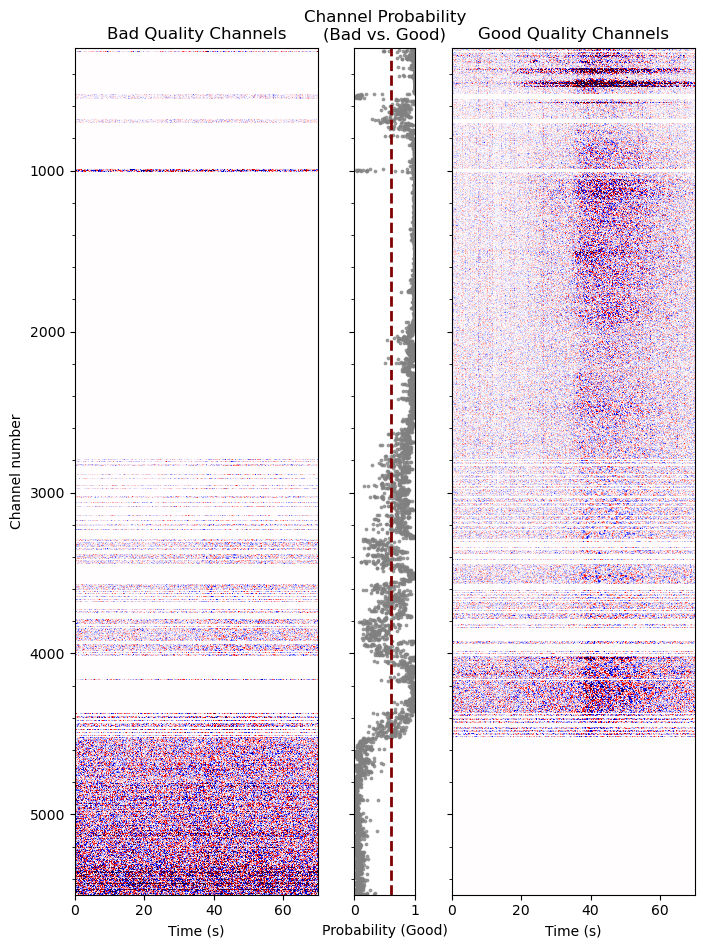

In [154]:
import matplotlib.pyplot as plt

def create_event_selection_plot(data_df, channel_probs, channel_nums, threshold = 0.1):
    
    fig, (ax_left, ax_mid, ax_right) = plt.subplots(
        1, 3, 
        figsize=(8, 11),  # adjust as needed for clarity
        gridspec_kw={'width_ratios': [8, 2, 8]},  # middle plot is narrower
        sharey=True  # share the y-axis (channels) among subplots
    )

    bad_ch_data = data_df.copy()
    good_ch_data = data_df.copy()
    cols_to_zero = channel_nums[channel_probs > threshold]
    bad_ch_data.loc[:, cols_to_zero] = 0
    cols_to_zero = channel_nums[channel_probs < threshold]
    good_ch_data.loc[:, cols_to_zero] = 0

    vmin, vmax = -5, 5
    first_sec, last_sec = 0, int(bad_ch_data.shape[0]/50)
    first_ch, last_ch = channel_nums.min(), channel_nums.max()

    # Left plot
    im_left = ax_left.imshow(
        bad_ch_data.T,      # transpose so y-axis=channels, x-axis=time
        vmin=vmin, 
        vmax=vmax, 
        aspect='auto', 
        cmap='seismic',
        interpolation='none',
        extent=[first_sec, last_sec, last_ch, first_ch]
    )
    ax_left.set_title("Bad Quality Channels")
    ax_left.set_xlabel("Time (s)")
    ax_left.set_ylabel("Channel number")
    ax_left.minorticks_on()
    ax_left.tick_params(axis='x', which='minor', bottom=False, )


    # Right plot
    im_right = ax_right.imshow(
        good_ch_data.T,      # transpose so y-axis=channels, x-axis=time
        vmin=vmin, 
        vmax=vmax, 
        aspect='auto', 
        cmap='seismic',
        interpolation='none',
        extent=[first_sec, last_sec, last_ch, first_ch]
    )
    ax_right.set_title("Good Quality Channels")
    ax_right.set_xlabel("Time (s)")
    #ax_left.set_ylabel("Channel number")
    ax_right.minorticks_on()
    ax_right.tick_params(axis='x', which='minor', bottom=False)


    ax_mid.scatter(channel_probs, channel_nums, 
                s=3, alpha=0.7, color='grey')  # scatter style

    ax_mid.axvline(threshold, color='maroon', linestyle='--', linewidth=2, label='Decision Threshold')
    ax_mid.set_xlim([0, 1])  # probabilities range from 0 to 1
    ax_mid.set_title("Channel Probability\n(Bad vs. Good)")
    ax_mid.set_xlabel("Probability (Good)")
    ax_mid.minorticks_on()
    ax_mid.tick_params(axis='x', which='minor', bottom=False)

    return fig

safe_t_feat_sel = drop_beta_feats(safe_t_feat)
safe_t_feat_sel = drop_env_mfcc(safe_t_feat_sel)
X_ood_safe_t = scaler.transform(safe_t_feat_sel.drop(columns='target'))
X_ood_safe_t = pd.DataFrame(X_ood_safe_t, columns=X_train.columns)
safe_t_channel_probs = calibrated_clf.predict_proba(X_ood_safe_t[selected_features])[:, 1]

safe_t_df = utils.import_h5('data/SAFE/ICM_2023-11-13_14-57-38.h5')
safe_t_df = utils.filter_imported_data(safe_t_df, freq=100, pass_low=3, pass_hi=20, decimate_data=True)
safe_t_df = utils.set_data_limits(safe_t_df, first_ch=236, first_time=3000, last_time=6500)
safe_t_channel_nums = safe_t_df.columns

safe_t_channel_probs_smooth = pd.Series(safe_t_channel_probs).ewm(alpha=0.5).mean().values
fig = create_event_selection_plot(safe_t_df, safe_t_channel_probs_smooth, safe_t_channel_nums, threshold=0.6)
fig.savefig("safe_t_selection_plot.pdf", dpi=300, bbox_inches='tight')
fig.savefig("safe_t_selection_plot.png", dpi=300, bbox_inches='tight')
plt.show()

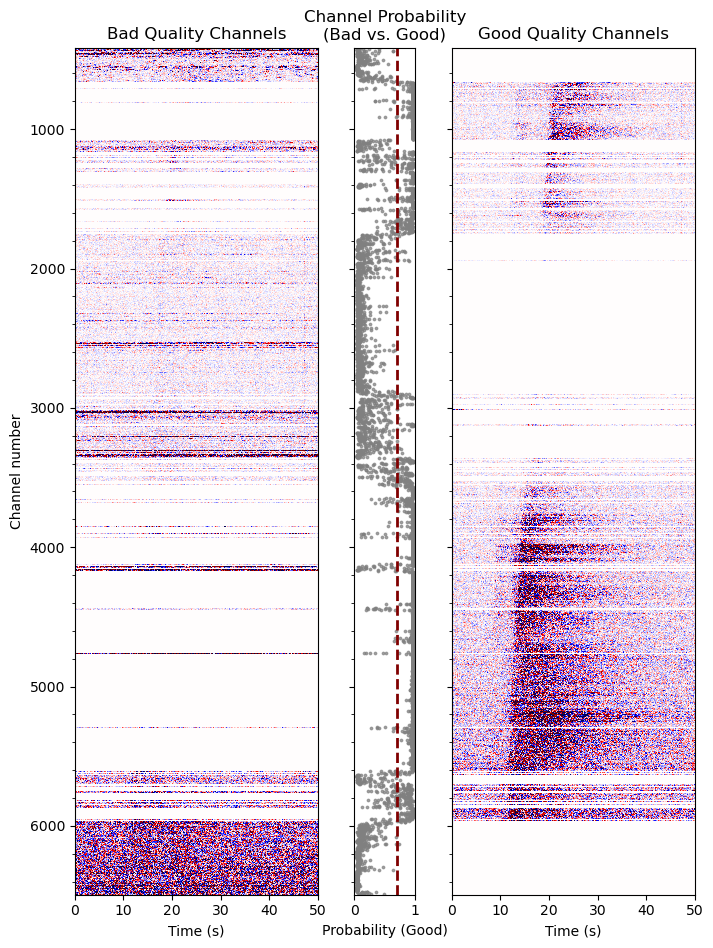

In [152]:
candas2_222_feat = pd.read_csv("features2/candas2_222_features.csv", index_col=0)

candas2_222_feat = drop_env_mfcc(candas2_222_feat)
X_candas222 = scaler.transform(candas2_222_feat)
X_candas222 = pd.DataFrame(X_candas222, columns=X_train.columns)
candas222_channel_probs = calibrated_clf.predict_proba(X_candas222[selected_features])[:, 1]

candas222_df = utils.import_h5('data/CANDAS2/CANDAS2_2023-02-22_07-01-14_filtered_2pn.h5')
candas222_df = utils.filter_imported_data(candas222_df, freq=50, pass_low=3, pass_hi=20, decimate_data=True)
candas222_df = utils.set_data_limits(candas222_df, first_ch=415, first_time=3000, last_time=5500)
candas222_channel_nums = candas222_df.columns

candas222_channel_probs_smooth = pd.Series(candas222_channel_probs).ewm(alpha=0.5).mean().values
fig = create_event_selection_plot(candas222_df, candas222_channel_probs_smooth, candas222_channel_nums, threshold=0.7)
fig.savefig("candas2_222_selection_plot.pdf", dpi=300, bbox_inches='tight')
fig.savefig("candas2_222_selection_plot.png", dpi=300, bbox_inches='tight')
plt.show()


## Threshold Decision Plots

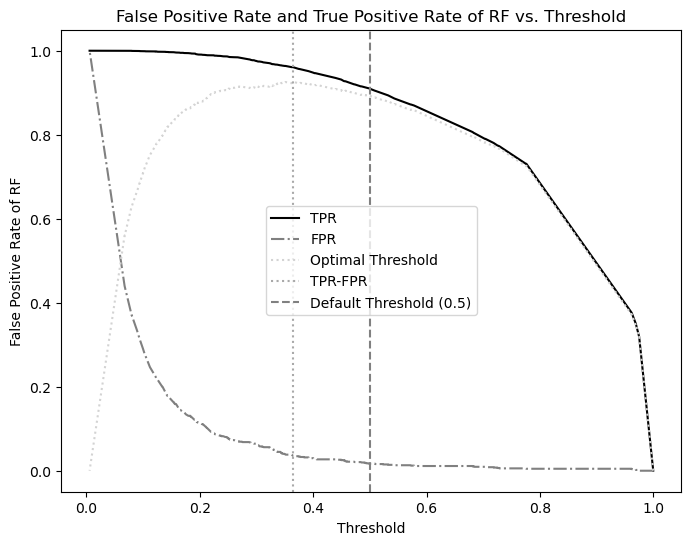

In [122]:
from sklearn.metrics import RocCurveDisplay, roc_curve

y_proba = calibrated_clf.predict_proba((X_ood_safe_t[selected_features]))[:, 1] 
y_proba = pd.Series(y_proba).ewm(alpha=0.5).mean().values
y_safe_t = safe_t_feat.target
fpr, tpr, thresholds = roc_curve(y_safe_t, y_proba)

# Plot FPR vs. Threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, tpr, label="TPR", color="black")
plt.plot(thresholds, fpr, label="FPR", color="gray", linestyle='-.')
plt.plot(thresholds, tpr-fpr, label='Optimal Threshold', color='lightgray', linestyle=':')
plt.axvline(x=thresholds[np.argmax(tpr-fpr)], color="darkgray", linestyle=":", label="TPR-FPR")
plt.xlabel("Threshold")
plt.ylabel("False Positive Rate of RF")
plt.title("False Positive Rate and True Positive Rate of RF vs. Threshold")
plt.axvline(x=0.5, color="gray", linestyle="--", label="Default Threshold (0.5)")
plt.legend()
#plt.grid()
plt.show()

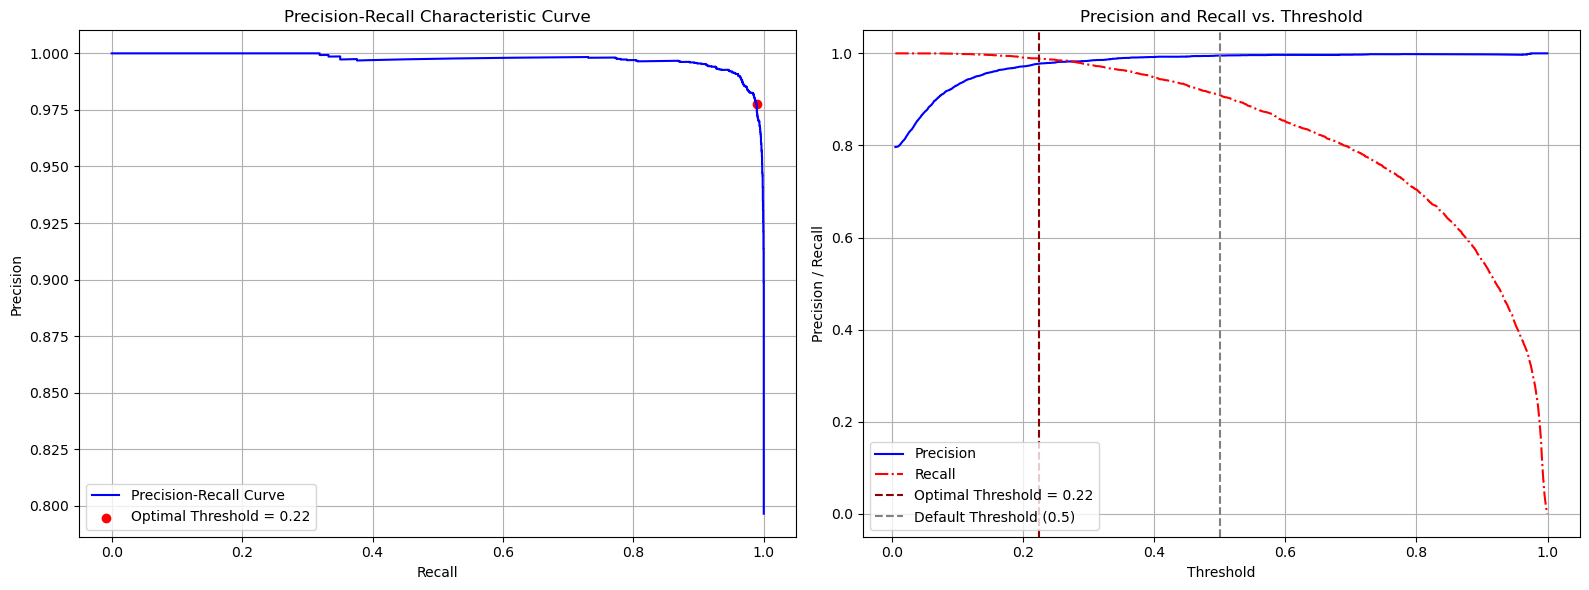

In [123]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# Generate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_safe_t, y_proba)

# Compute F1-score for each threshold
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])

# Find the optimal threshold that maximizes F1-score
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left subplot: Precision-Recall characteristic curve
axes[0].plot(recall, precision, color='blue', label="Precision-Recall Curve")
axes[0].scatter(recall[optimal_idx], precision[optimal_idx], color='red', label=f"Optimal Threshold = {optimal_threshold:.2f}")
axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Precision")
axes[0].set_title("Precision-Recall Characteristic Curve")
axes[0].legend()
axes[0].grid(True)

# Right subplot: Precision/Recall vs. Threshold
axes[1].plot(thresholds, precision[:-1], label="Precision", color="blue")
axes[1].plot(thresholds, recall[:-1], label="Recall", color="red", linestyle='-.')
axes[1].axvline(x=optimal_threshold, color="darkred", linestyle="--", label=f"Optimal Threshold = {optimal_threshold:.2f}")
axes[1].axvline(x=0.5, color="gray", linestyle="--", label="Default Threshold (0.5)")
axes[1].set_xlabel("Threshold")
axes[1].set_ylabel("Precision / Recall")
axes[1].set_title("Precision and Recall vs. Threshold")
axes[1].legend()
axes[1].grid(True)

# Show the plots
plt.tight_layout()
plt.show()


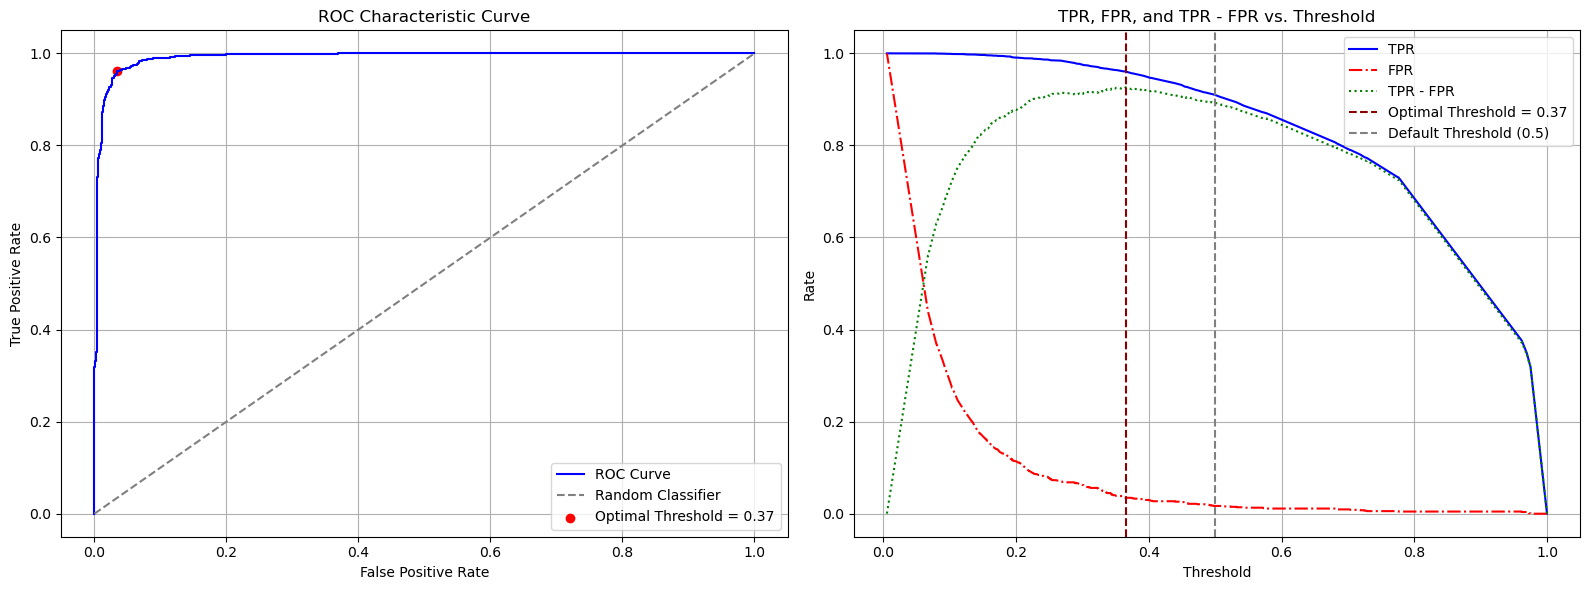

In [124]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Generate FPR, TPR, and thresholds for ROC
fpr, tpr, thresholds = roc_curve(y_safe_t, y_proba)

# Compute the optimal threshold by maximizing TPR - FPR
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left subplot: ROC characteristic curve (TPR vs. FPR)
axes[0].plot(fpr, tpr, color='blue', label="ROC Curve")
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")
axes[0].scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f"Optimal Threshold = {optimal_threshold:.2f}")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Characteristic Curve")
axes[0].legend()
axes[0].grid(True)

# Right subplot: TPR/FPR vs. Threshold
axes[1].plot(thresholds, tpr, label="TPR", color="blue")
axes[1].plot(thresholds, fpr, label="FPR", color="red", linestyle='-.')
axes[1].plot(thresholds, tpr - fpr, label="TPR - FPR", color="green", linestyle=':')
axes[1].axvline(x=optimal_threshold, color="darkred", linestyle="--", label=f"Optimal Threshold = {optimal_threshold:.2f}")
axes[1].axvline(x=0.5, color="gray", linestyle="--", label="Default Threshold (0.5)")
axes[1].set_xlabel("Threshold")
axes[1].set_ylabel("Rate")
axes[1].set_title("TPR, FPR, and TPR - FPR vs. Threshold")
axes[1].legend()
axes[1].grid(True)

# Show the plots
plt.tight_layout()
plt.show()


## Signal Examples and Shap waterfall plots

In [125]:
tf_same_day_df = utils.import_h5("data/CANDAS/TF/ZI.T20200727_1305.h5")
tf_same_day_df = utils.filter_imported_data(tf_same_day_df, pass_low=3, pass_hi=20, decimate_data=True)
tf_same_day_df = utils.set_data_limits(tf_same_day_df, first_ch=745, first_time=4500, last_time=7500)


tf_same_day_feat_cl = drop_env_mfcc(drop_beta_feats(tf_same_day_feat))
X_tf_0727 = scaler.transform(tf_same_day_feat_cl.drop(columns='target'))
X_tf_0727 = pd.DataFrame(X_tf_0727, 
                              columns=X_train.columns)
y_tf_0727 = tf_same_day_feat['target']
tf_same_day_channel_nums = tf_same_day_df.columns
tf_same_day_channel_probs = xgb_clf_best.predict_proba(X_tf_0727[selected_features])[:, 1]


In [126]:
print(tf_same_day_channel_nums[np.argsort(tf_same_day_channel_probs)][-10:])
print(np.argsort(tf_same_day_channel_probs)[-10:])

Index([1289, 3253, 3269, 2521, 3254, 3359, 3262, 3257, 3266, 3255], dtype='int64')
[ 544 2508 2524 1776 2509 2614 2517 2512 2521 2510]


In [127]:
print(tf_same_day_channel_nums[np.argsort(tf_same_day_channel_probs)][3000:3003])
print(np.argsort(tf_same_day_channel_probs)[3000:3003])

Index([3764, 1790, 2387], dtype='int64')
[3019 1045 1642]


In [128]:
import shap
explainer = shap.TreeExplainer(xgb_clf_best)
explanation = explainer(X_tf_0727[selected_features])

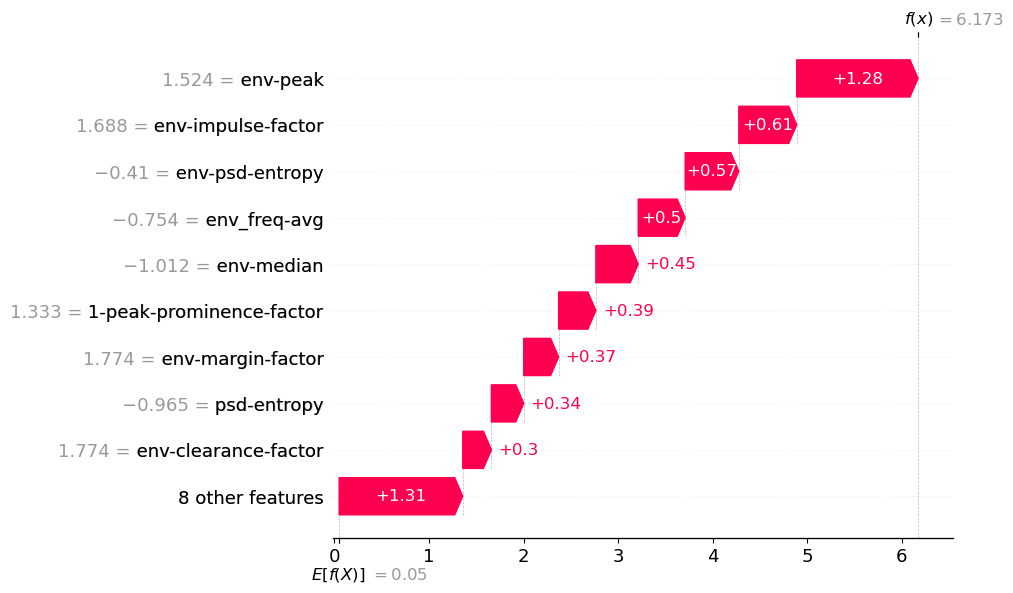

In [129]:
shap.plots.waterfall(explanation[1776], max_display=10)

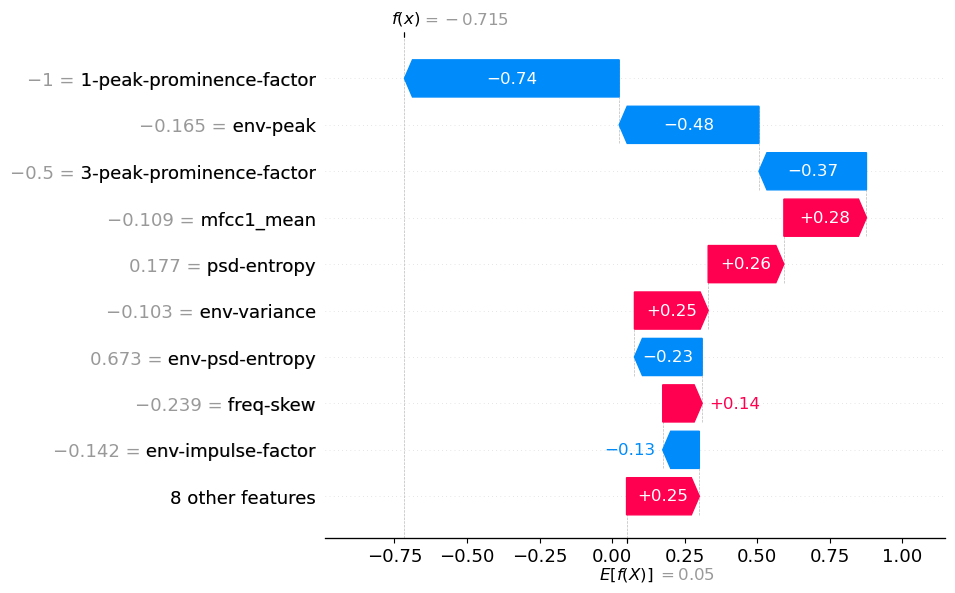

In [130]:
shap.plots.waterfall(explanation[2810], max_display=10)

/var/folders/6h/1kty6sjd4xb2_2xqj9t3dx1r0000gn/T/ipykernel_14266/4075752482.py:212: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


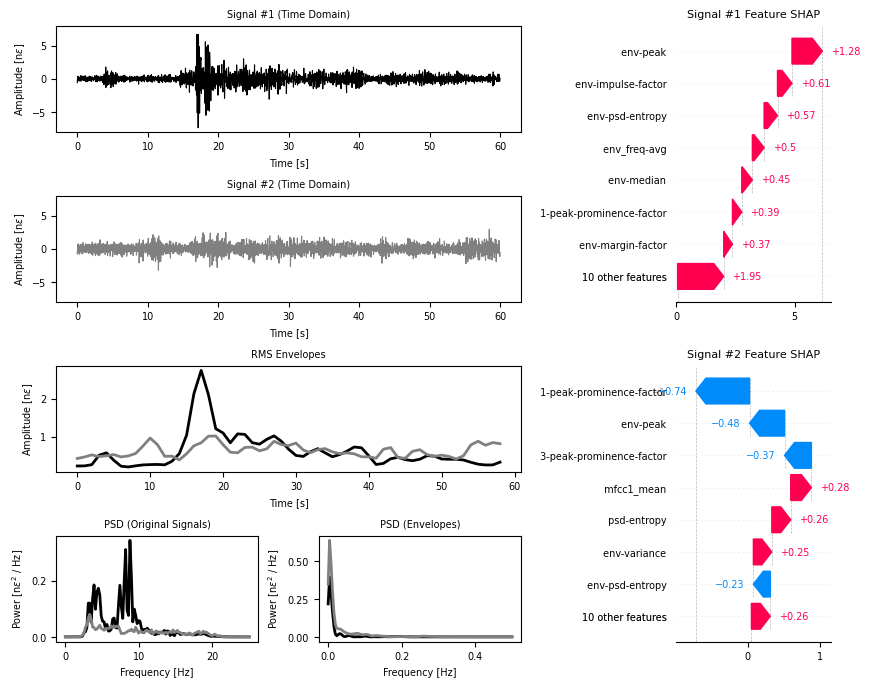

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from matplotlib.mlab import psd

# -----------
# Helpers
# -----------

plt.rcParams.update({
    'font.size': 6,        # General font size
    'axes.titlesize': 6,   # Title font size
    'axes.labelsize': 5,   # Label font size
    'xtick.labelsize': 4,   # X-axis tick labels
    'ytick.labelsize': 4,   # Y-axis tick labels
    'legend.fontsize': 4    # Legend font size
})

def plot_shap_waterfall(ax, explanation, max_display=8, font_size=6):
    """
    Plot SHAP waterfall on the given axis with custom font size.
    """
    plt.sca(ax)
    shap.plots.waterfall(explanation, max_display=max_display, show=False)

    old_labels = [tick.get_text() for tick in ax.get_yticklabels()]
    new_labels = []
    for lbl in old_labels:
        # if there's an '=', keep only the left side (the feature name)
        if "=" in lbl:
            lbl = lbl.split("=")[0].strip()
        if '.' in lbl: 
            lbl=''
        new_labels.append(lbl)
    #ax.set_yticklabels([], fontsize=font_size)
    ax.set_yticklabels(new_labels, fontsize=font_size)

    # 4) Move y ticks/labels to the right, hide the left spine
    #ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.spines["left"].set_visible(False)

    all_axes = ax.figure.axes
    for subax in all_axes:
        xtickstr = str(subax.get_xticklabels())
        if 'f(x)' in xtickstr or 'f(X)' in xtickstr:
            # This removes the entire axis (and its labels).
            subax.remove()
    
    for text in ax.get_figure().findobj(match=plt.Text):
        text.set_fontsize(font_size)


def rms(values):
    return np.sqrt(np.mean(np.square(values)))

def make_envelope(data, window_size):
    """
    Compute an RMS envelope with 50% overlap.
    If original Fs=50 Hz and window_size=100, then
    envelope Fs_env ~ 1 Hz.
    """
    step = window_size // 2  # 50% overlap
    env = []
    for start in range(0, len(data) - window_size + 1, step):
        segment = data[start : start + window_size]
        env.append(rms(segment))
    return np.array(env)

def calculate_psd(series, Fs=50):
    """
    Calculate the PSD for one Pandas Series (single channel).
    Returns (power, freqs).
    """
    power, freqs = psd(series.values, Fs=Fs)
    return power, freqs

# -----------
# Main plotting function
# -----------

def plot_two_channels(
    data_df, ch_num1, ch_num2,
    explanation1, explanation2,
    window_size=100
):
    """
    Plot:
      - Row 0: Signal #1 in time domain
      - Row 1: Signal #2 in time domain
      - Row 2: Both envelopes overlaid
      - Row 3: Two subplots side-by-side: 
         left  => PSD of both signals overlaid
         right => PSD of both envelopes overlaid
      - Right side: two SHAP waterfall plots stacked vertically
    """
    # -------------------------------------------------------------------------
    # 1) Extract the two signals
    # -------------------------------------------------------------------------
    y1 = data_df[ch_num1].values
    y2 = data_df[ch_num2].values

    # Suppose sampling rate is 50 Hz
    Fs = 50.0
    t = np.arange(len(y1)) / Fs  # time axis for the signals

    # -------------------------------------------------------------------------
    # 2) Create envelopes
    # -------------------------------------------------------------------------
    env1 = make_envelope(y1, window_size)
    env2 = make_envelope(y2, window_size)
    Fs_env = Fs / (window_size / 2)  # e.g., 1 Hz if window_size=100
    t_env = np.arange(len(env1)) / Fs_env

    # -------------------------------------------------------------------------
    # 3) Calculate PSDs
    # -------------------------------------------------------------------------
    # PSD for original signals
    psd1, freqs = calculate_psd(pd.Series(y1), Fs=Fs)
    psd2, _     = calculate_psd(pd.Series(y2), Fs=Fs)

    # PSD for envelopes
    psd_env1, freqs_env = calculate_psd(pd.Series(env1), Fs=Fs_env)
    psd_env2, _         = calculate_psd(pd.Series(env2), Fs=Fs_env)

    # -------------------------------------------------------------------------
    # 4) Construct figure and GridSpec
    # -------------------------------------------------------------------------
    # Make it large
    fig = plt.figure()

    # 4 rows, 2 columns: left side wide, right side narrow
    # We'll stack the SHAP plots in column 1 (right side).
    gs = fig.add_gridspec(
        nrows=4, ncols=2,
        width_ratios=[3, 1],  # left is wide, right is narrow
        height_ratios=[1, 1, 1, 1],
        wspace=0.5, hspace=0.6
    )

    # --- Left side subplots ---
    ax_left_0 = fig.add_subplot(gs[0, 0])  # Row 0
    ax_left_1 = fig.add_subplot(gs[1, 0])  # Row 1
    ax_left_2 = fig.add_subplot(gs[2, 0])  # Row 2
    # Row 3 => subgrid with 1 row × 2 columns (psd of signals, psd of envelopes)
    subgrid_psd = gs[3, 0].subgridspec(nrows=1, ncols=2, wspace=0.3)
    ax_psd_orig = fig.add_subplot(subgrid_psd[0, 0])
    ax_psd_env  = fig.add_subplot(subgrid_psd[0, 1])

    # --- Right side subplots (two rows stacked) for SHAP waterfalls ---
    # We'll have top half for explanation1, bottom half for explanation2
    ax_right_top = fig.add_subplot(gs[0:2, 1])  # rows 0-1
    ax_right_bot = fig.add_subplot(gs[2:4, 1])  # rows 2-3

    # -------------------------------------------------------------------------
    # 5) Plot on the left
    # -------------------------------------------------------------------------
    ylim = 8
    # Row 0: Signal #1
    ax_left_0.plot(t, y1, 'black', linewidth=0.8)
    #ax_left_0.set_ylabel(f"Signal {ch_num1}")
    ax_left_0.set_ylabel(r"Amplitude [n$\varepsilon$]")
    ax_left_0.set_title("Signal #1 (Time Domain)")
    ax_left_0.set_xlabel("Time [s]")
    ax_left_0.set_ylim([-ylim, ylim])

    # Row 1: Signal #2
    ax_left_1.plot(t, y2, 'gray', linewidth=0.8)
    ax_left_1.set_ylabel(r"Amplitude [n$\varepsilon$]")
    ax_left_1.set_title("Signal #2 (Time Domain)")
    ax_left_1.set_xlabel("Time [s]")
    ax_left_1.set_ylim([-ylim, ylim])

    # Row 2: Overlaid envelopes
    ax_left_2.plot(t_env, env1, 'black', label=f"Env {ch_num1}", linewidth=2.0)
    ax_left_2.plot(t_env, env2, 'gray', label=f"Env {ch_num2}", linewidth=2.0)
    #ax_left_2.legend(loc='upper right')
    ax_left_2.set_xlabel("Time [s]")
    ax_left_2.set_ylabel(r"Amplitude [n$\varepsilon$]")
    ax_left_2.set_title("RMS Envelopes")

    # Row 3: side-by-side PSDs
    # Left subplot: original signals (overlaid)
    ax_psd_orig.plot(freqs, psd1, 'black', label=f"Signal {ch_num1}", linewidth=2.0)
    ax_psd_orig.plot(freqs, psd2, 'gray', label=f"Signal {ch_num2}", linewidth=2.0)
    #ax_psd_orig.legend(loc='upper right')
    ax_psd_orig.set_xlabel("Frequency [Hz]")
    ax_psd_orig.set_ylabel(r"Power [n$\varepsilon ^2$ / Hz]")
    ax_psd_orig.set_title("PSD (Original Signals)")

    # Right subplot: envelope PSD (overlaid)
    ax_psd_env.plot(freqs_env, psd_env1, 'black', label=f"Env {ch_num1}", linewidth=2.0)
    ax_psd_env.plot(freqs_env, psd_env2, 'gray', label=f"Env {ch_num2}", linewidth=2.0)
    #ax_psd_env.legend(loc='upper right')
    ax_psd_env.set_xlabel("Frequency [Hz]")
    ax_psd_env.set_ylabel(r"Power [n$\varepsilon ^2$ / Hz]")
    ax_psd_env.set_title("PSD (Envelopes)")

    # -------------------------------------------------------------------------
    # 6) Plot SHAP waterfalls on the right
    # -------------------------------------------------------------------------
    # For shap.plots.waterfall, we typically do `show=False` so we can embed:
        # Plot SHAP waterfalls on the right
    plot_shap_waterfall(ax_right_top, explanation1, font_size=7)
    plot_shap_waterfall(ax_right_bot, explanation2, font_size=7)

    ax_right_top.set_title("Signal #1 Feature SHAP", fontdict={'fontsize':8})
    ax_right_bot.set_title("Signal #2 Feature SHAP", fontdict={'fontsize':8})
    # Adjust layout
    fig.set_size_inches(10, 8)
    plt.tight_layout()
    fig.savefig("example_signals.pdf")
    fig.savefig("example_signals.png", dpi=300, bbox_inches='tight')
    plt.show()

import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
#plt.rcParams["mathtext.fontset"] = "cm"

plot_two_channels(
    data_df=tf_same_day_df,
    ch_num1=2521,
    ch_num2=3555,
    explanation1=explanation[1776],
    explanation2=explanation[2810]
)
